### Defining the aoi

In [1]:
import pandas as pd
import numpy as np
import xarray as xa
from pathlib import Path
import src.data.ecostress_io as eio
import src.data.ecostress_stack as es
import src.data.era_stack_resample as esr
import rioxarray
import sys
import geopandas as gpd
import json
import dask
from dask.distributed import Client
import os
import matplotlib.pyplot as plt
xa.set_options(display_style='html')
n_partitions = 8 # set in the files
root_path = Path("/raid/scratch/rave/san-pedro-ecostress-landsat-8-2019-2019")
reanalysis_path = Path(root_path, "era5-download-sanpedro.nc")
bounds_tuple = ( -110.9508, 30.9688, -109.2614, 33.02797)
xmin, ymin, xmax, ymax = bounds_tuple  # hardcoding since concattenating 1000s of ecostress files with different overlaps hangs

/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


### Subsetting global rivers dataset
This dataset needs to be examined more closely. some second order streams appear to be missed and I'm not sure if channels are digitized as river.

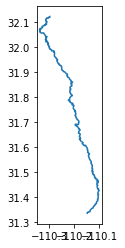

In [2]:
san_pedro_river_df = gpd.read_file(Path(root_path, "san_pedro_river_osm.geojson"))
san_pedro_river_df.plot()

### making path lists to products

In [3]:
l3qa_path = Path(root_path, "ECO3ANCQA")
et_inst_path = Path(root_path, "ECO3ETPTJPL-inst/")
esi_path = Path(root_path, "ECO4ESIPTJPL") # this only came with PET from appeears
l2_cloud_path = Path(root_path, "L2CLOUD")
l2_lst_path = Path(root_path, "L2LST")

# tempdir_daily = root_path/"tmp-daily-nearest"
# whole_tif_etdaily_paths, csv_et_paths, xml_et_paths = eio.separate_by_pattern(et_path, "*ETdaily*.tif")

tempdir_esi = root_path/"tmp-PET-nearest"
whole_tif_PET_paths, csv_esi_paths, xml_esi_paths = eio.separate_by_pattern(esi_path, "*Evaporative_Stress_Index*PET*.tif")

tempdir_inst = root_path/"tmp-inst-nearest"
whole_tif_etinst_paths, csv_etinst_paths, xml_etinst_paths = eio.separate_by_pattern(et_inst_path, "*ETinst_*.tif")

tempdir_inst_uncertainty = root_path/"tmp-inst_uncertainty-nearest"
whole_tif_etinst_uncertainty_paths, csv_etinst_uncertainty_paths, xml_etinst_uncertainty_paths = eio.separate_by_pattern(et_inst_path, "*ETinstUncertainty*.tif")

tempdir_l3qa = root_path/"tmp-l3qa"
whole_tif_l3qa_paths, csv_qa_paths, xml_qa_paths = eio.separate_by_pattern(l3qa_path)

tempdir_l2qa = root_path/"tmp-l2qa"
whole_tif_l2qa_paths, csv_l2qa_paths, xml_l2qa_paths = eio.separate_by_pattern(l2_lst_path, "*SDS_QC*.tif")

tempdir_l2cloud = root_path/"tmp-l2cloud"
whole_tif_l2cloud_paths, csv_l2cloud_paths, xml_l2cloud_paths = eio.separate_by_pattern(l2_cloud_path, "*SDS_CloudMask*.tif")

In [4]:
from geocube.api.core import make_geocube
x = eio.read_ecostress_scene(whole_tif_etinst_uncertainty_paths[0])
resolution = x.rio.resolution()
x.close()

buffer = 500 # units in meters
san_pedro_river_df = gpd.GeoDataFrame(geometry=[san_pedro_river_df.geometry.unary_union], crs=san_pedro_river_df.crs)
san_pedro_river_df = san_pedro_river_df.to_crs(epsg=32612)\
                                                .buffer(buffer)\
                                                .to_crs(epsg=4326) # buffers by 5000 meters
san_pedro_river_df = gpd.GeoDataFrame(geometry=[san_pedro_river_df.geometry.unary_union], crs=san_pedro_river_df.crs)
san_pedro_river_df['500m_riparian_corridor_buffer'] = 1
san_pedro_arr = make_geocube(vector_data=san_pedro_river_df, resolution=resolution)


aoi_grid = eio.gdf_to_dataarray(san_pedro_river_df, san_pedro_river_df.crs, resolution) # necessary to get transforma attr, can't just use san_pedro_arr

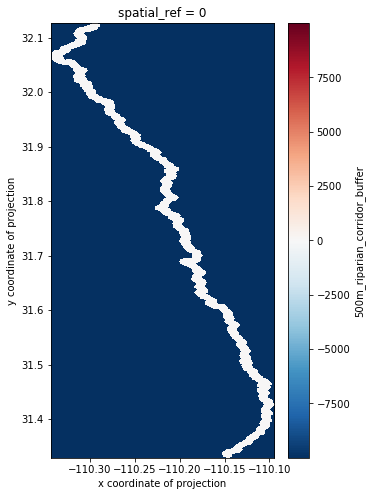

In [5]:
san_pedro_arr['500m_riparian_corridor_buffer'].plot.imshow(figsize=(5,8))

Making the aoi grid for resampling

In [6]:
from rasterio.enums import Resampling
# etdaily_tseries_paths = es.clip_resample_ecostress(whole_tif_etdaily_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_daily, resampling_method=Resampling.nearest)
etinst_tseries_paths = es.clip_resample_ecostress(whole_tif_etinst_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_inst, resampling_method=Resampling.nearest)
etinst_uncertainty_tseries_paths = es.clip_resample_ecostress(whole_tif_etinst_uncertainty_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_inst_uncertainty , resampling_method=Resampling.nearest)
# l3qa_tseries_paths = es.clip_resample_ecostress_no_dask(whole_tif_l3qa_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_l3qa, resampling_method=Resampling.nearest)
l2qa_tseries_paths = es.clip_resample_ecostress_no_dask(whole_tif_l2qa_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_l2qa, resampling_method=Resampling.nearest)
l2cloud_tseries_paths = es.clip_resample_ecostress_no_dask(whole_tif_l2cloud_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_l2cloud, resampling_method=Resampling.nearest)
PET_tseries_paths = es.clip_resample_ecostress_no_dask(whole_tif_PET_paths, bounds_tuple, aoi_grid, filter_nan=True, tempdir=tempdir_esi, resampling_method=Resampling.nearest)

In [7]:
etinst_da_list = eio.read_scenes(etinst_tseries_paths, chunks = {"band":1})
# l3qa_tseries, etinst_da_list = es.read_and_concat(l3qa_tseries_paths, etinst_da_list)
l2qa_tseries, etinst_da_list = es.read_and_concat(l2qa_tseries_paths, etinst_da_list)
l2cloud_tseries, etinst_da_list = es.read_and_concat(l2cloud_tseries_paths, etinst_da_list)
etinst_uncertainty_tseries, etinst_da_list = es.read_and_concat(etinst_uncertainty_tseries_paths, etinst_da_list)
petinst_tseries, etinst_da_list = es.read_and_concat(PET_tseries_paths, etinst_da_list)
etinst_tseries = xa.concat(etinst_da_list, dim="date").sortby('date')

In [8]:
etinst_tseries = etinst_tseries.persist()
etinst_uncertainty_tseries = etinst_uncertainty_tseries.persist()
l2cloud_tseries = l2cloud_tseries.persist()
l2qa_tseries = l2qa_tseries.persist()
petinst_tseries = petinst_tseries.persist()
# l3qa_tseries = l3qa_tseries.persist()

In [9]:
etinst_tseries

,Array,Chunk
Bytes,252.23 MB,2.00 MB
Shape,"(126, 1, 1267, 395)","(1, 1, 1267, 395)"
Count,126 Tasks,126 Chunks
Type,float32,numpy.ndarray


In [10]:
san_pedro_arr

<xarray.Dataset>
Dimensions:                        (x: 395, y: 1267)
Coordinates:
  * y                              (y) float64 31.33 31.33 31.33 ... 32.13 32.13
  * x                              (x) float64 -110.1 -110.1 ... -110.3 -110.3
    spatial_ref                    int64 0
Data variables:
    500m_riparian_corridor_buffer  (y, x) float64 -9.999e+03 ... -9.999e+03
Attributes:
    grid_mapping:  spatial_ref

#### bit order for qa masks follows landsat, right to left for bit ordering, left to right for each double bit that represent conditions.
https://www.usgs.gov/land-resources/nli/landsat/landsat-collection-1-level-1-quality-assessment-band?qt-science_support_page_related_con=0#qt-science_support_page_related_con

In [11]:
from src.data import qa_filter
ints_to_keep = qa_filter.get_good_qa_ints_to_keep_l2qa()

### Bad L2 flag filtering

In [12]:
nonnan_count_without_masking = (etinst_tseries > 0).sum()

nomask_count = nonnan_count_without_masking.compute()

l2qa_mask = l2qa_tseries.isin(ints_to_keep)

etinst_l2qamasked = xa.ufuncs.logical_and(l2qa_mask, (etinst_tseries > 0))

# nonnan_count_with_masking = etinst_l2qamasked.sum()

# l2qa_masked_count = nonnan_count_with_masking.compute()

# l2qa_masked_count/nomask_count

In [13]:
cloud_ints_to_keep = qa_filter.get_good_qa_ints_to_keep_l2cloud()

In [14]:
l2cloud_mask = l2cloud_tseries.isin(cloud_ints_to_keep)

In [15]:
etinst_l2allmask = xa.ufuncs.logical_and(l2cloud_mask, etinst_l2qamasked)

nonnan_count_with_masking = etinst_l2allmask.sum()

l2qacloud_masked_count = nonnan_count_with_masking.compute()

l2qacloud_masked_count/nomask_count

<xarray.DataArray ()>
array(0.66845507)

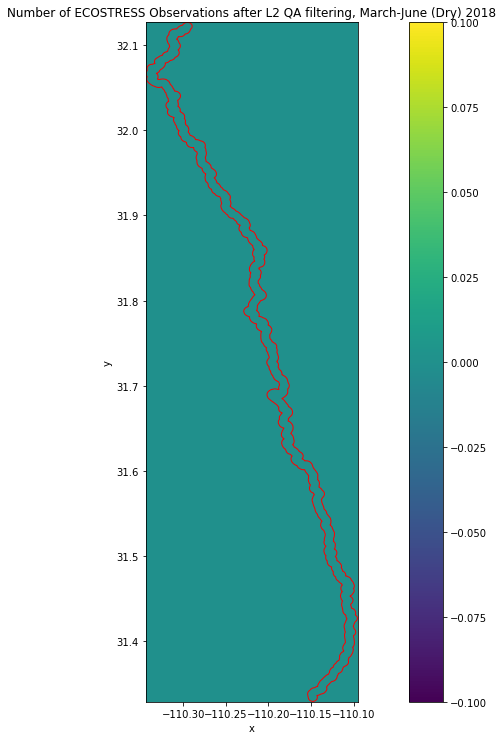

In [16]:
et_2018_june_sept=etinst_l2allmask.sel(date=slice("2018-03-01", "2018-06-30"))

true_count = et_2018_june_sept.sel(band=1).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations after L2 QA filtering, March-June (Dry) 2018")
san_pedro_river_df.plot(ax=ax, edgecolor="red", facecolor="none")
f.set_size_inches(18.5, 12.5)

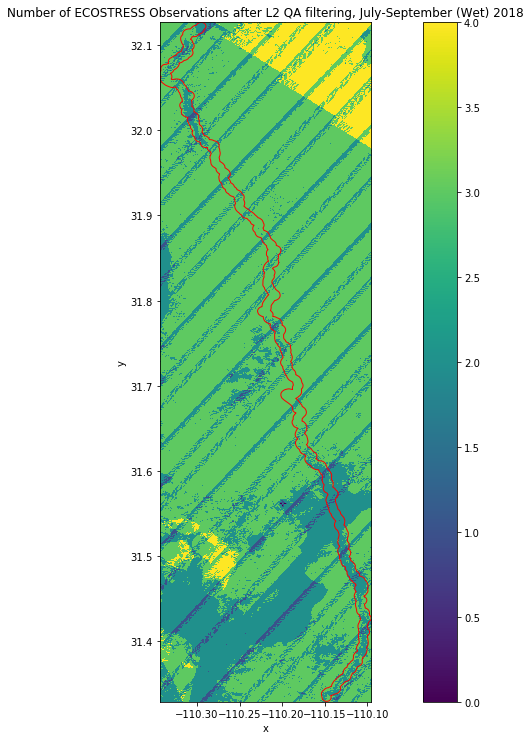

In [17]:
et_2018_june_sept=etinst_l2allmask.sel(date=slice("2018-07-01", "2018-09-30"))

true_count = et_2018_june_sept.sel(band=1).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations after L2 QA filtering, July-September (Wet) 2018")
san_pedro_river_df.plot(ax=ax, edgecolor="red", facecolor="none")
f.set_size_inches(18.5, 12.5)

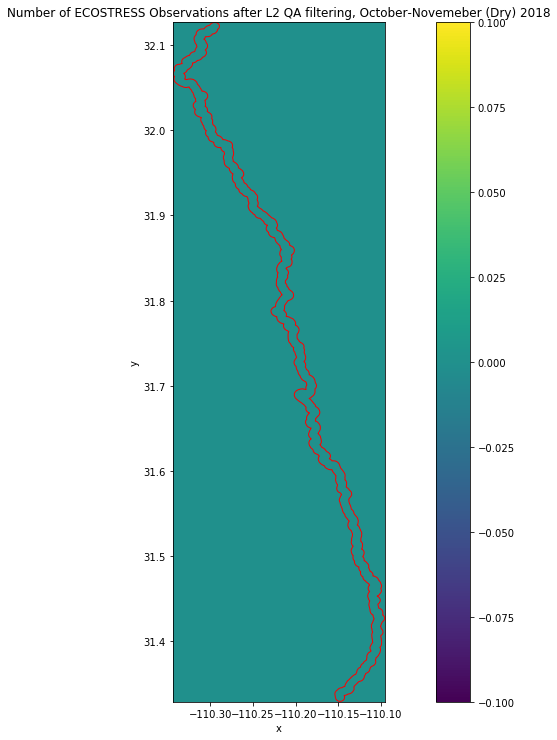

In [18]:
et_2018_june_sept=etinst_l2allmask.sel(date=slice("2018-10-01", "2018-11-30"))

true_count = et_2018_june_sept.sel(band=1).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations after L2 QA filtering, October-Novemeber (Dry) 2018")
san_pedro_river_df.plot(ax=ax, edgecolor="red", facecolor="none")
f.set_size_inches(18.5, 12.5)

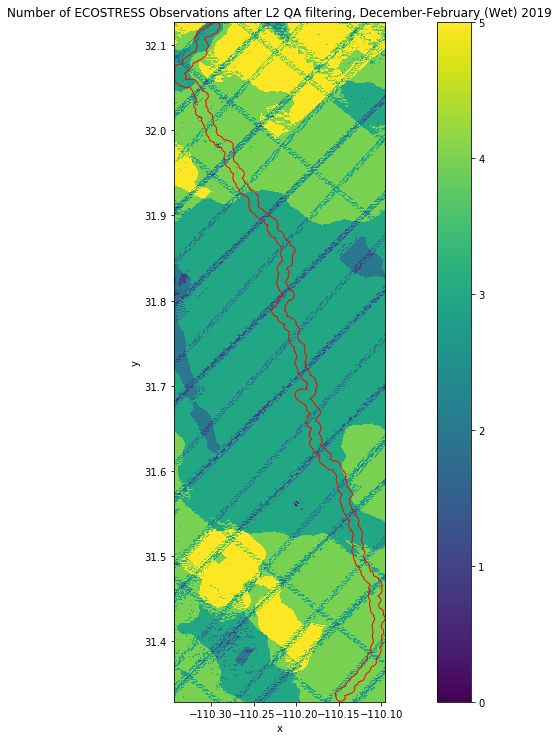

In [19]:
et_2018_june_sept=etinst_l2allmask.sel(date=slice("2018-12-01", "2019-02-28"))

true_count = et_2018_june_sept.sel(band=1).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations after L2 QA filtering, December-February (Wet) 2019")
san_pedro_river_df.plot(ax=ax, edgecolor="red", facecolor="none")
f.set_size_inches(18.5, 12.5)

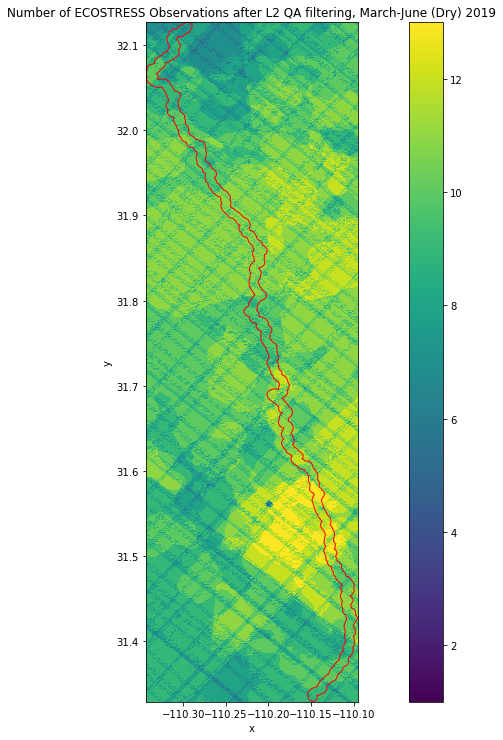

In [20]:
et_2018_june_sept=etinst_l2allmask.sel(date=slice("2019-03-01", "2019-06-30"))

true_count = et_2018_june_sept.sel(band=1).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations after L2 QA filtering, March-June (Dry) 2019")
san_pedro_river_df.plot(ax=ax, edgecolor="red", facecolor="none")
f.set_size_inches(18.5, 12.5)

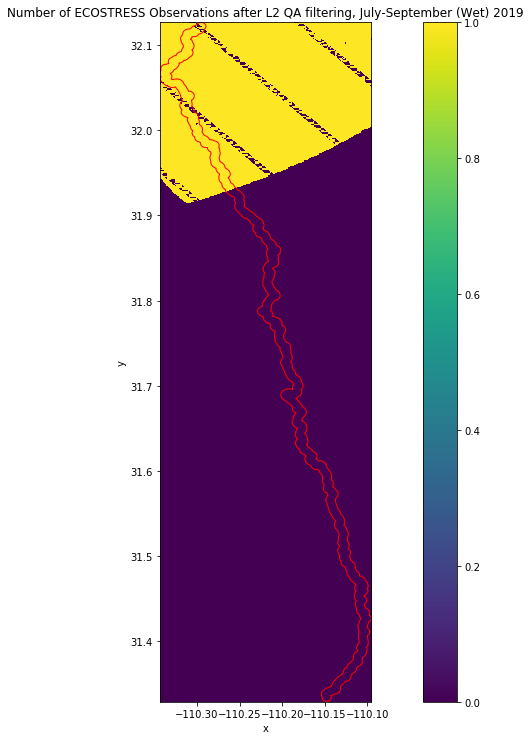

In [21]:
et_2018_june_sept=etinst_l2allmask.sel(date=slice("2019-07-01", "2019-09-30"))

true_count = et_2018_june_sept.sel(band=1).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations after L2 QA filtering, July-September (Wet) 2019")
san_pedro_river_df.plot(ax=ax, edgecolor="red", facecolor="none")
f.set_size_inches(18.5, 12.5)

In [22]:
# et_2019_june_sept=etinst_l2allmask.sel(date=slice("2019-06-01", "2019-09-30"))

# true_count = et_2019_june_sept.sel(band=1).sum(dim="date")

# true_count_c = true_count.compute()

# f, ax = plt.subplots(1)
# true_count_c.plot.imshow(ax=ax)
# plt.title("Number of ECOSTRESS Observations after L2 QA filtering, June-Sept 2019")
# rivers_df.cx[xmin:xmax, ymin:ymax].plot(ax=ax, edgecolor="red")
# f.set_size_inches(18.5, 10.5)

In [23]:
etinst_tseries.name = "ECO3ETPTJPL"
etinst_tseries = etinst_tseries.sel(date=slice("2019-03-01", "2019-06-30"))\
        .where(etinst_l2allmask.sel(date=slice("2019-03-01", "2019-06-30")))
etinst_uncertainty_tseries = etinst_uncertainty_tseries.sel(date=slice("2019-03-01", "2019-06-30"))\
        .where(etinst_l2allmask.sel(date=slice("2019-03-01", "2019-06-30")))
petinst_tseries = petinst_tseries.sel(date=slice("2019-03-01", "2019-06-30"))\
        .where(etinst_l2allmask.sel(date=slice("2019-03-01", "2019-06-30")))
# l2cloud_tseries = l2cloud_tseries.sel(date=slice("2018-01-01", "2018-12-31"))
# l2qa_tseries = l2qa_tseries.sel(date=slice("2018-01-01", "2018-12-31"))
# l3qa_tseries = l3qa_tseries.sel(date=slice("2018-01-01", "2018-12-31"))

In [24]:
def merge_dups_et_da(etinst_tseries, var_name):
    """
    Shifts instantaneous measurements to nearest hours and averages pixels with duplicates.
    """
    
    et_tseries_ds = etinst_tseries.to_dataset().sel(band=1)

    et_tseries_ds_nearest_hour_times = [pd.to_datetime(i.strftime("%Y-%m-%d %H")) for i in pd.to_datetime(et_tseries_ds.date.values)]

    et_tseries_ds['date'] = et_tseries_ds_nearest_hour_times

    et_tseries_ds.attrs['units'] = "W/m^2"

    et_concat_ds = es.merge_duplicates(et_tseries_ds, etinst_tseries, var_name)

    return et_concat_ds

etinst_tseries = merge_dups_et_da(etinst_tseries,"ECO3ETPTJPL")
petinst_tseries.name = "PET"
petinst_tseries = merge_dups_et_da(petinst_tseries,"PET")
etinst_uncertainty_tseries.name = "Actual ET Uncertainty"
etinst_uncertainty_tseries = merge_dups_et_da(etinst_uncertainty_tseries, "Actual ET Uncertainty")

### Processing ERA Land Reanalysis data, or reading it if it has been previously processed and saved

9km nominal resolution is downsampled to Ecostress resolution on a 4326 geographic grid spanning the bounding box defined above. The hourly ERA had to be processed month by month and then concatenated together and resaved at the dest_path. See era_stack_resample and ecostress_stack for how these files were created.

Only resampling a singly dry season of vpd, read era vpd func hardcodes the march-june dry season for 2019

In [33]:
dest_path = root_path/"resampled_era_san_pedro.tif"
if dest_path.exists() is False:
    resampled_vpd_ds = esr.reproject_era_hourly_san_pedro(reanalysis_path, dest_path, aoi_grid)
    vpd_et_times = esr.intersect_et_vpd_times(etinst_tseries, resampled_vpd_ds)
    vpd_et_times.to_netcdf(dest_path)
else:
    vpd_et_times = xa.open_dataset(dest_path)['Hourly_VPD_6am-8pm_utc_Resampled.nc']
    vpd_et_times.name = "ERA5 Land VPD"

In [43]:
et_vpd_san_pedro = etinst_tseries.rename({"date":"time"}).merge(vpd_et_times.to_dataset())

In [44]:
et_vpd_san_pedro = et_vpd_san_pedro.merge(petinst_tseries.rename({"date":"time"})).merge(etinst_uncertainty_tseries.rename({"date":"time"}))

In [45]:
et_vpd_san_pedro 

<xarray.Dataset>
Dimensions:                (time: 18, x: 395, y: 1267)
Coordinates:
    band                   int64 1
  * y                      (y) float64 31.33 31.33 31.33 ... 32.13 32.13 32.13
  * x                      (x) float64 -110.1 -110.1 -110.1 ... -110.3 -110.3
  * time                   (time) datetime64[ns] 2019-03-03T17:00:00 ... 2019-06-23T13:00:00
    spatial_ref            int64 0
Data variables:
    ECO3ETPTJPL            (time, y, x) float32 dask.array<chunksize=(1, 1267, 395), meta=np.ndarray>
    ERA5 Land VPD          (time, y, x) float32 ...
    PET                    (time, y, x) float32 dask.array<chunksize=(1, 1267, 395), meta=np.ndarray>
    Actual ET Uncertainty  (time, y, x) float32 dask.array<chunksize=(1, 1267, 395), meta=np.ndarray>
Attributes:
    units:    W/m^2

In [ ]:
# et_vpd_rhone = et_vpd_rhone.chunk({'time': -1, "y":500, "x":500}) # time axis needs to be one chunk for correlation

In [48]:
# from scipy.signal import correlate

# s_res = correlate(et_vpd_rhone['ECO3ETPTJPL'], et_vpd_rhone['Hourly_VPD_6am-8pm_utc_Resampled.nc'], mode="same")

In [49]:
def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=0) * y.std(axis=0))

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=0, keepdims=False))
            * (y - y.mean(axis=0, keepdims=False))).mean(axis=0)

# can't ge these to work but funcs above run fast, time needs to be in first position
def pearson_correlation(x, y, dim):
    return xa.apply_ufunc(
        pearson_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

def covariance(x, y, dim):
    return xa.apply_ufunc(
        covariance_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

In [47]:
et_vpd_san_pedro['ECO3ETPTJPL'] = et_vpd_san_pedro['ECO3ETPTJPL'].where(~np.isnan(et_vpd_san_pedro['ERA5 Land VPD']))
et_vpd_san_pedro['ERA5 Land VPD'] = et_vpd_san_pedro['ERA5 Land VPD'].where(~np.isnan(et_vpd_san_pedro['ECO3ETPTJPL']))

In [51]:
pearson_nokeep_dim = pearson_correlation_gufunc(et_vpd_san_pedro['ECO3ETPTJPL'], et_vpd_san_pedro['ERA5 Land VPD'])

In [52]:
r = pearson_nokeep_dim.compute()

/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/distributed/worker.py:3235: UserWarning: Large object of size 9.01 MB detected in task graph: 
  (array([[[ True,  True,  True, ...,  True,  True,  ... 0, 395, None)))
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


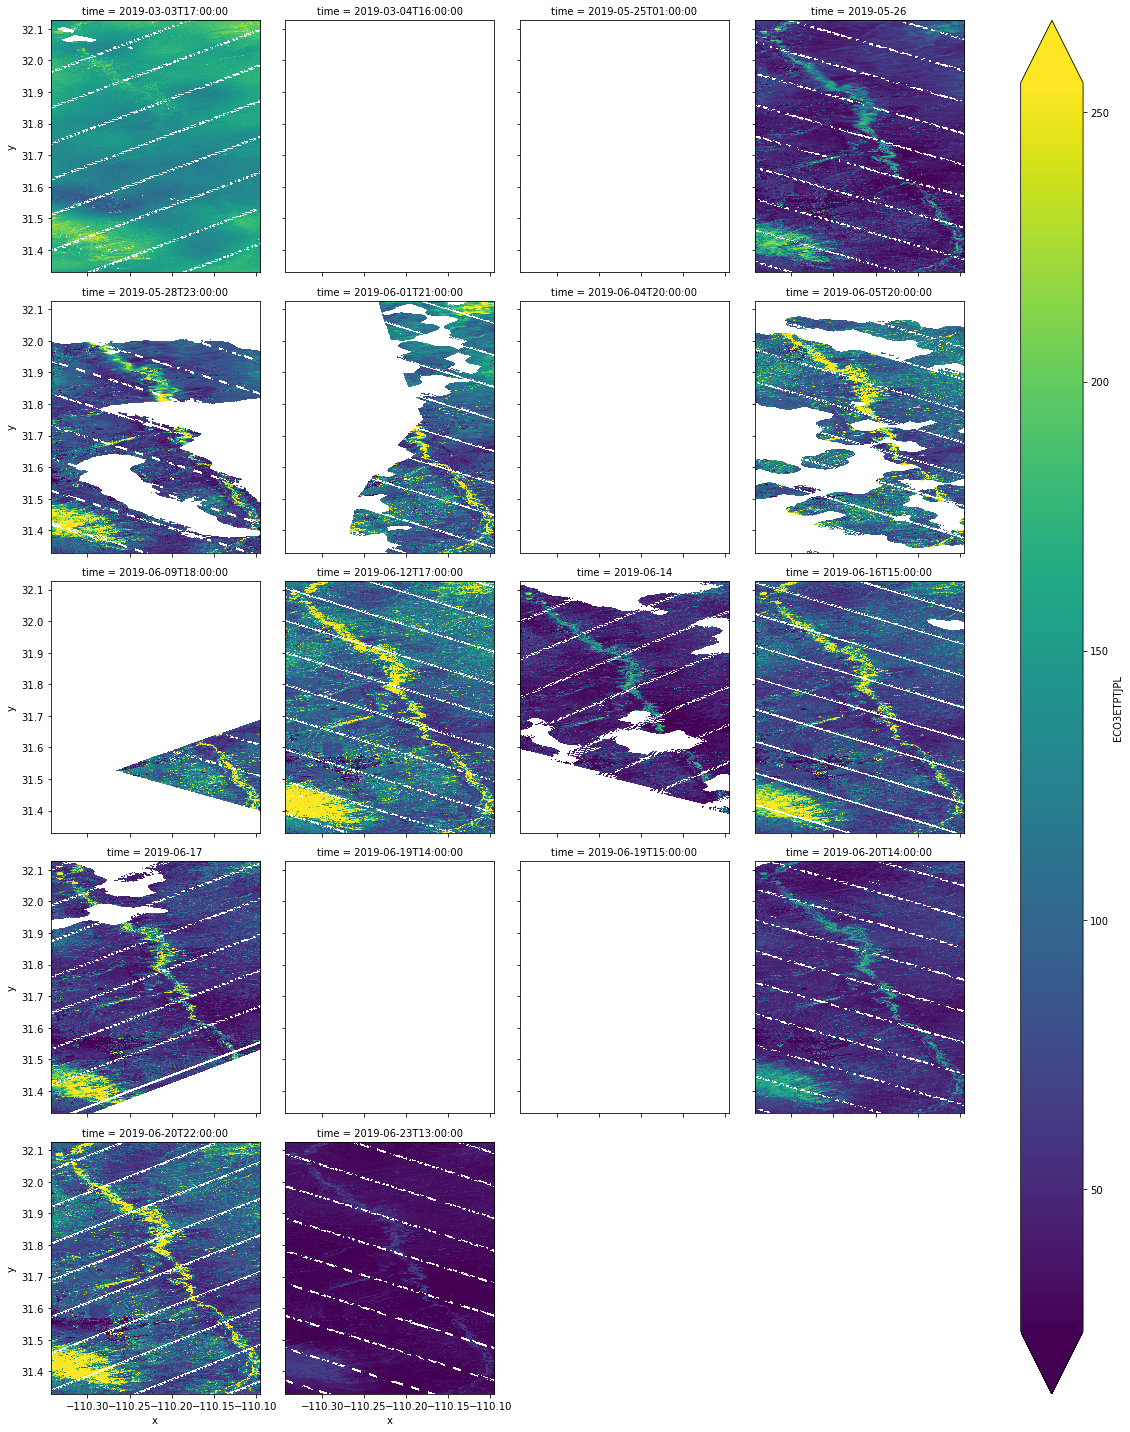

In [85]:

et_vpd_san_pedro['ECO3ETPTJPL'].plot.imshow(x='x', y='y', col='time', col_wrap=4, robust=True, cmap='viridis', size=4)

need to inspect uncertainty now and remove uncertain ones like image at index 14

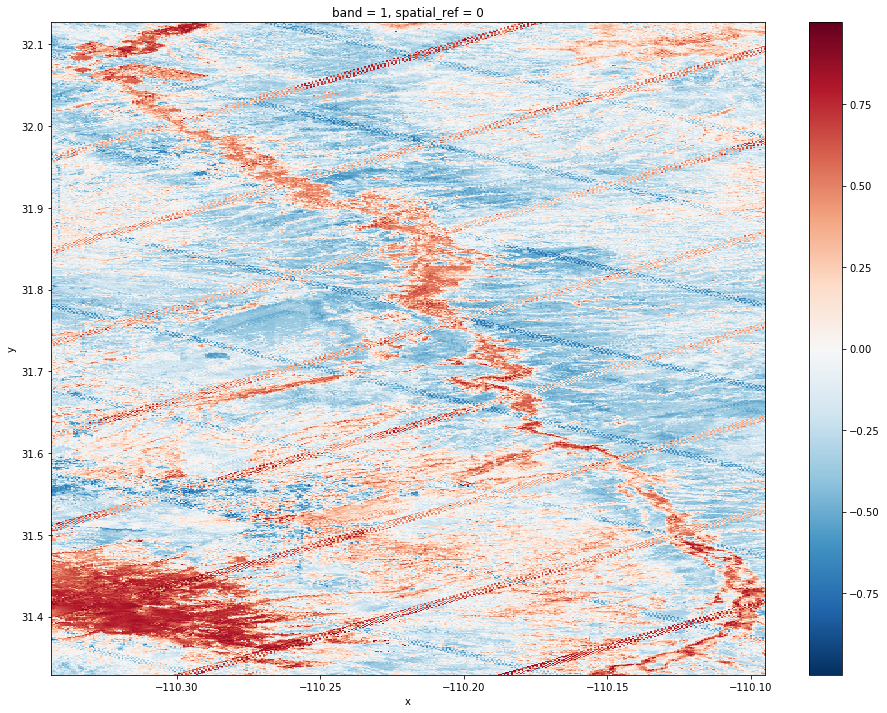

In [86]:

r.plot.imshow(figsize=(16,12))

In [74]:
x = eio.read_ecostress_scene(whole_tif_etinst_paths[1])

In [78]:
aoi_grid.rio.bounds()

(-110.09516892450307,
 32.12683537173757,
 -110.34393100420505,
 31.32890738444038)

In [79]:
x.attrs

{'transform': (0.000629777416967,
  0.0,
  -110.11533846155385,
  0.0,
  -0.000629777416967,
  33.02849578610604),
 'crs': '+init=epsg:4326',
 'res': (0.000629777416967, 0.000629777416967),
 'is_tiled': 1,
 'nodatavals': (-9999999999999.0,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'add_offset': '0',
 'AREA_OR_POINT': 'Area',
 'build_id': '0503',
 'orbit_number': '01084',
 'scale_factor': '1',
 'scene_id': '013',
 'units': 'W/m^2'}

In [80]:
r.rio.write_crs(x.rio.crs, inplace=True)

# r.rio.update_attrs(etinst_tseries.attrs, inplace=True)

r.rio.to_raster(root_path/"et_vpd_correlation_san_pedro.tif")

In [272]:
def non_nan_obs_arr(arr, dimsum):

    arr = ~np.isnan(arr)

    true_count = arr.sum(dim=dimsum)

    return true_count.compute()

In [277]:
observation_count = non_nan_obs_arr(et_vpd_rhone['ECO3ETPTJPL'], "time")

/home/rave/miniconda3/envs/geo/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [280]:
observation_count.astype(float)

<xarray.DataArray 'ECO3ETPTJPL' (y: 4573, x: 2620)>
array([[12., 12., 12., ...,  0.,  0.,  0.],
       [12., 12., 12., ...,  0.,  0.,  0.],
       [12., 12., 12., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  5.,  6.,  4.],
       [ 0.,  0.,  0., ...,  6.,  5.,  6.],
       [ 0.,  0.,  0., ...,  6.,  6.,  5.]])
Coordinates:
    band         int64 1
  * y            (y) float64 43.38 43.38 43.38 43.38 ... 46.25 46.26 46.26 46.26
  * x            (x) float64 6.185 6.185 6.184 6.183 ... 4.538 4.537 4.537 4.536
    spatial_ref  int64 0

In [281]:
observation_count = observation_count.astype(float)
observation_count.rio.write_crs(etinst_tseries.rio.crs, inplace=True)

observation_count.rio.update_attrs(etinst_tseries.attrs, inplace=True)

observation_count.rio.to_raster(root_path/"et_vpd_correlation_observation_count.tif")

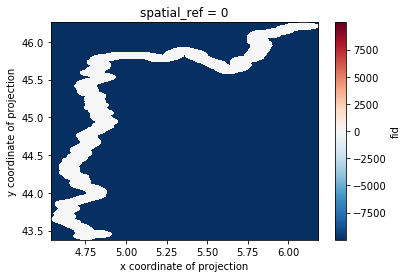

In [103]:
rhone_arr['fid'].plot.imshow()

Calcualting distance from outlet

In [ ]:
rhone_arr['fid'] = rhone_arr['fid'].where(rhone_arr['fid']!=-9999.0)

In [169]:
rhone_coords = np.array(list(zip(rhone_arr['fid']['x'].values, rhone_arr['fid']['y'].values)))

In [173]:
outlet_coord = [(4.74, 43.4),]

In [174]:
from scipy.spatial import distance

In [175]:
distance_arr = distance.cdist(rhone_coords, outlet_coord, 'euclidean')

In [177]:
distance_arr.shape

(2620, 1)

In [178]:
rhone_coords.shape

(2620, 2)

In [179]:
rhone_arr['fid'].shape

(4573, 2620)

30m DEM from http://srtm.csi.cgiar.org/download

In [133]:
srtm_37_04 = xa.open_rasterio(root_path/"srtm_37_04.tif", chunks={"x":500, "y":500})
srtm_38_03 = xa.open_rasterio(root_path/"srtm_38_03.tif", chunks={"x":500, "y":500})
srtm_38_04 = xa.open_rasterio(root_path/"srtm_38_04.tif", chunks={"x":500, "y":500})

srtm_concatted = xa.concat([srtm_37_04, srtm_38_03, srtm_38_04], dim="band")

srtm_merged = srtm_concatted.sum(dim="band")

srtm_merged = srtm_merged.where(srtm_merged!=-32768.0)

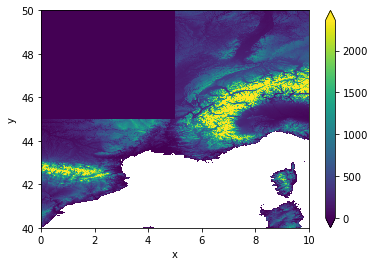

In [137]:
srtm_merged.plot.imshow(robust = True)

In [ ]:
def non_nan_obs_arr():

    et_2018_may_sept = et_2018_may_sept.where(et_2018_may_sept > 0)

    et_nonnan_count = ~np.isnan(et_2018_may_sept)

    true_count = et_nonnan_count.astype(bool).sum(dim="date")

    true_count_c = true_count.compute()

In [24]:
#from xhistogram.xarray import histogram

In [44]:
#xa.plot.hist(etinst_uncertainty_tseries.where(etinst_uncertainty_tseries > 0), figsize=(12,6), bins=100)

In [45]:
#xa.plot.hist(etinst_tseries.where(etinst_tseries > 0), figsize=(12,6), bins=100)

In [31]:
#etinst_tseries_uncetaintylt50 = etinst_tseries.where(etinst_tseries != -1e+13).where(etinst_uncertainty_tseries < 150)

# merge is incorrect, need to debug

In [ ]:
import numpy.ma as ma

A = [1, 2, 3, 4, 5, np.NaN]
B = [2, 3, 4, 5.25, np.NaN, 100]

print(ma.corrcoef(ma.masked_invalid(A), ma.masked_invalid(B)))

Correlation ignoring nans with xarray options and helpful links
- https://stackoverflow.com/questions/31619578/numpy-corrcoef-compute-correlation-matrix-while-ignoring-missing-data
- http://martin-jung.github.io/post/2018-xarrayregression/
- https://github.com/pydata/xarray/pull/3550

#### Daily ET processing, focusing on isnt ET first since it looks to be more reliable based on intersecting scene comparison

Need to merge ET arrays taken on same date together to reduce time coord duplicates that occur because of partial scene overlaps and large aoi. nanmean should replace nans with a true value, 2 or more true values with the mean for that day (should only happena t the overlaps, infrequently), and all nan slices with nan.

Below I'm working on joining vpd and et by time and removing duplicates

Profiling why there are edge effects between ET Daily Scenes

In [ ]:
duplicate_dates = [pd.to_datetime(date).strftime("%Y-%m-%d") for date in duplicate_dates]


In [ ]:
resampled_data_arrays[0]['date'].dt.month.values

In [ ]:
for path in whole_tif_etdaily_paths:
    if "2018222" in str(path):
        print(path)

In [ ]:
resampled_data_arrays_profile = []
for da in resampled_data_arrays:
    if str(da.date.dt.month.values) == "8" and str(da.date.dt.year.values) == "2018" and str(da.date.dt.day.values) == "10":
        resampled_data_arrays_profile.append(da.where(da!=-1e+13))

In [ ]:
resampled_data_arrays_profile[0][0].plot.imshow()

In [ ]:
resampled_data_arrays_profile[1][0].plot.imshow()

In [ ]:
resampled_data_arrays_profile[-1][0].plot.imshow()

Instantaeous uncertainty

In [ ]:
inst_uncertainty_paths = ["/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinstUncertainty_doy2018222131552_aid0001.tif",
"/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinstUncertainty_doy2018222180613_aid0001.tif",
"/mnt/ecostress/rhone-ecostress-data/ECO3ETPTJPL/ECO3ETPTJPL.001_EVAPOTRANSPIRATION_PT_JPL_ETinstUncertainty_doy2018222180704_aid0001.tif"]

In [ ]:
inst_uncertainty_paths = [Path(path) for path in inst_uncertainty_paths]

In [ ]:
clipped_uncertainty_paths = eio.clip_and_save(inst_uncertainty_paths, bounds_tuple, filter_nan = True, outDir=Path('/home/ryan/work/'))

In [ ]:
uncertainty_scenes = eio.read_scenes([Path(path) for path in clipped_uncertainty_paths])


In [ ]:
uncertainty_scenes[0][0].attrs['units'] = "W/m^2"
uncertainty_scenes[0][0].plot.imshow(figsize=(10,10))

In [ ]:
uncertainty_scenes[1][0].plot.imshow(figsize=(10,10))

In [ ]:
uncertainty_scenes[2][0].plot.imshow(figsize=(10,10))

Plotting histograms where scenes intersect

In [ ]:
date_to_plot = duplicate_dates[1]
n_scenes = len(et_tseries_ds_dups.sel(time=date_to_plot)['time'])
data_to_plot = et_tseries_ds_dups["ECO3ETPTJPL"].sel(time=date_to_plot).drop("band")

In [ ]:
valid_intersect_data = data_to_plot.where((data_to_plot[0] > 0) & (data_to_plot[1] > 0) & (data_to_plot[2] > 0))

In [ ]:
f, ax = plt.subplots(1)
xa.plot.hist(valid_intersect_data[0],ax=ax, alpha=.6, bins = 25)
xa.plot.hist(valid_intersect_data[1],ax=ax, alpha=.6, bins = 25)
xa.plot.hist(valid_intersect_data[2],ax=ax, alpha=.6, bins = 25)
plt.title("Instantaneous ET Disagreement between the intersection of 3 Ecostress scenes on August 10, 2018, France")

In [ ]:
data_to_plot['time'] = [0, 1, 2]
data_to_plot.attrs['units'] = "W/m^2"
data_to_plot.plot.imshow(x='x', y='y', col='time', col_wrap=n_scenes, robust=True, figsize=(20,8))
# plt.title(f"{n_scenes} individual scenes for date {date_to_plot}", fontsize=20)

In [ ]:
f,ax = plt.subplots(1)
date_to_plot = duplicate_dates[1]
et_vpd_ds["ECO3ETPTJPL"].sel(time=date_to_plot).plot.imshow(ax=ax)
f.set_size_inches(18.5, 10.5)
n_scenes = len(et_tseries_ds_dups.sel(time=date_to_plot)['time'])
plt.title(f"{n_scenes} scenes for date {date_to_plot}, mean taken at overlaps", fontsize=20)

Plotting ecostress availability

In [ ]:
et_tseries = et_tseries.sel(band=1)

In [ ]:
et_2018_may_sept=et_tseries.sel(date=slice("2018-06-01", "2018-09-30"))

et_2018_may_sept=et_2018_may_sept.chunk(chunks={"date": 101, "y": 1000, "x": 1000})

et_2018_may_sept = et_2018_may_sept.where(et_2018_may_sept > 0)

et_nonnan_count = ~np.isnan(et_2018_may_sept)

true_count = et_nonnan_count.astype(bool).sum(dim="date")

true_count_c = true_count.compute()

f, ax = plt.subplots(1)
true_count_c.plot.imshow(ax=ax)
plt.title("Number of ECOSTRESS Observations, May-Sept 2018")
france_river_lines.plot(ax=ax, color="red")
f.set_size_inches(18.5, 10.5)

Aggregating hourly data to dekad

In [ ]:
pev_dekad = met_dataset['pev'].resample(time='1D').sum().resample(time='10D').mean()

pev_dekad_2018 = pev_dekad.sel(time=slice("2018-01-01", "2018-10-01"))

met_dataset['pev'].sel(time="2019-04-01")

pev_dekad_2019.plot(x='longitude', y='latitude', col='time', col_wrap=5)

## pretty ET plotting

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
%matplotlib inline

ETcolors = ["#f6e8c3", "#d8b365", "#99974a", "#53792d", "#6bdfd2", "#1839c5"]
ETcmap = LinearSegmentedColormap.from_list("ET", ETcolors)
date_utc = pd.to_datetime(et['date'].values)
layer_type = et.attrs['filename'].split("_")[-3]
title = 'ECO3ETPTJPL Evapotranspiration'

fig = plt.figure(figsize=(9.7,7.6))                                                       # Set the figure size (x,y)
fig.suptitle(f'{title} ({layer_type}) \n at {date_utc}', fontsize=22)  # Add title for the plots
plt.axis('off')                                                                           # Remove axes from plot
im = plt.imshow(et.sel(band=1), cmap=ETcmap);                                                        # Plot array using colormap
# plt.scatter(Tcol, Trow, color="black", marker='x')                                        # Plot tower location
# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.004, label=f"ET ({et.attrs['units']})", shrink=0.6).outline.set_visible(True)

## Code graveyard

trying to plot xarray image data and geopandas data with ipyleaflet but it can't do image overlays yet (unless it comes from a server via url potentially)

In [ ]:
import ipyleaflet as ipyl
envelope = rhone_river_df.unary_union.envelope
x = france_river_lines.unary_union.envelope.centroid.xy[0][0]
y = france_river_lines.unary_union.envelope.centroid.xy[1][0]
e, n, w, s =true_count_c.rio.bounds()
m = ipyl.Map(center = (y,x), zoom=6)

rivers_data = ipyl.GeoData(geo_dataframe = france_river_lines,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Rivers')
m.add_layer(rivers_data)
plt.imsave("observation_count.jpeg",true_count_c)
obs_heatmap = ipyl.ImageOverlay(
    url="observation_count.jpeg",
    bounds=((s, w), (n, e))
)

m.add_layer(obs_heatmap)
m

trying to plot ecostress DataArray with geopandas shapes

In [ ]:
def cartopy_project_geo_df(df, crs):

    # This can be converted into a `proj4` string/dict compatible with GeoPandas
    crs_proj4 = crs.proj4_init
    return df.to_crs(crs_proj4)

crs = ccrs.PlateCarree()
aoi_projected = cartopy_project_geo_df(aoi, crs)
france_rivers_df_projected = cartopy_project_geo_df(france_rivers_df, crs)
# base = aoi_projected.plot(color="grey", edgecolor="black")
# france_rivers_df_projected.plot(ax=base, color="blue")


import cartopy.crs as ccrs
import matplotlib.pyplot as plt
ax = plt.axes(projection=crs)
all_et_daily[14].sel(band=1).plot.imshow(ax=ax, transform=crs)
# ax.add_geometries(aoi_projected['geometry'], crs=crs)
ax.add_geometries(france_rivers_df_projected['geometry'], crs=crs)

In [ ]:
def mask_NA_values():
    """
    Daily ET products have both nan values from where there are clouds 
    and -1e+13 for where the ecostress swath was clipped during the ordering process
    """
    masked_et = np.ma.masked_where(et.sel(band=1) == np.nan, et.sel(band=1))
    masked_et = np.ma.masked_where(masked_et == -1e+13, masked_et)

In [ ]:
base = aoi.plot(color="grey", edgecolor="black")

france_rivers_df.plot(ax=base, color="blue")

In [ ]:
#profiling bad vals in correlation result, fixed by setting nans between arrs

bad_vals = r.where(r == np.max(r).values)

bad_vals = r.where(~np.isnan(bad_vals))

bad_cov = cov_r.where(~np.isnan(bad_vals))

np.unique(bad_cov)

np.unique(et_vpd_rhone['ECO3ETPTJPL'].std(axis=0).where(~np.isnan(bad_vals)))

flat_index = np.argmax(et_vpd_rhone['Hourly_VPD_6am-8pm_utc_Resampled.nc'].std(axis=0).where(~np.isnan(bad_vals))).values

np.unravel_index(flat_index, et_vpd_rhone['Hourly_VPD_6am-8pm_utc_Resampled.nc'].std(axis=0).shape)

et_vpd_rhone['Hourly_VPD_6am-8pm_utc_Resampled.nc'][:,866, 2266].values

pearson_correlation_gufunc(et_vpd_rhone['ECO3ETPTJPL'][:,866, 2266].values, )

np.unique(et_vpd_rhone['Hourly_VPD_6am-8pm_utc_Resampled.nc'].std(axis=0).where(~np.isnan(bad_vals)))

np.unique(et_vpd_rhone['Hourly_VPD_6am-8pm_utc_Resampled.nc'].where(~np.isnan(bad_vals)))

np.unique(et_vpd_rhone['ECO3ETPTJPL'].where(~np.isnan(bad_vals)))

100.73461 / (50.597702* 1.1021457)

bad_vals.plot.imshow(robust=True)